
Interactive QC tool for manual scout-slice exclusion
===================================================

* Works on your **processed .npy volumes** (shape: (N, 512, 512))
* Uses only ipywidgets + matplotlib (already present in JupyterLab)
* Lets you:
    – choose how many thumbnails per screen (10 / 30 / 50 …)
    – browse *per-patient* (one patient at a time)
    – click a thumbnail ➜ opens full slice slider
    – tick “Exclude” to mark whole series for omission
    – live table of flagged volumes
    – export to CSV

Assumptions
-----------
* Manifest CSV with at least:

    patient_id, phase_name, npy_path   # extra columns are shown automatically

* “Processed” volumes reside on the same server & are readable with `np.load`


import os
import pathlib
import csv
import json
import numpy as np
import pandas as pd
import ipywidgets as w
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plt.ioff()  # avoid extra figures popping up

In [1]:
import os
import io
import pathlib
import csv
import json
import numpy as np
import pandas as pd
import ipywidgets as w
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plt.ioff()  # avoid extra figures popping up

In [2]:
# ---------- CONFIG ----------
MANIFEST_PATH = "/mnt/tcia_data/processed/RIDER Lung CT/manifest.csv"   # change if needed
DEFAULT_THUMB_COUNT = 10                  # initial thumbnails per screen
THUMB_OPTIONS = [10, 30, 50]              # user-selectable


# ---------- Utility ----------
def load_center_slice(npy_path: str) -> np.ndarray:
    """Load centre slice (axial) as 2-D uint8 array for thumbnail display."""
    vol = np.load(npy_path, mmap_mode="r")
    mid = vol.shape[0] // 2
    sl = vol[mid]                     # shape (512, 512)
    sl_norm = 255 * (sl - sl.min()) / max(1e-5, (np.ptp(sl)))  # [0,255]
    return sl_norm.astype(np.uint8)


def show_slice(ax, img, title=""):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(title, fontsize=9)

In [ ]:
manifest = pd.read_csv(MANIFEST_PATH)
if not {"patient_id", "phase_percent", "file_path"}.issubset(manifest.columns):
    raise ValueError("Manifest must include patient_id, phase_percent, file_path")

patients = sorted(manifest["patient_id"].unique())
flagged = set()   # {(patient_id, phase_percent)}

# ---------- Widgets ----------
patient_dd = w.Dropdown(
    options=patients,
    description="Patient",
    layout=w.Layout(width="250px"),
)

thumb_count_dd = w.Dropdown(
    options=THUMB_OPTIONS,
    value=DEFAULT_THUMB_COUNT,
    description="# thumbs",
    layout=w.Layout(width="150px"),
)

export_btn = w.Button(description="Export flagged → CSV", button_style="info")
auto_detect_btn = w.Button(description="Auto-detect scouts", button_style="warning")
flagged_out = w.Output()
viewer_out = w.Output()

# Container for thumbnail grid
thumb_grid = w.GridBox(layout=w.Layout(grid_template_columns="repeat(5, 120px)"))


In [4]:
df = pd.read_csv(MANIFEST_PATH)
df.head()

,patient_id,phase_id,phase_percent,series_dir,file_path,num_slices,height,width,dtype
0,RIDER-2016615262,0,0,/mnt/tcia_data/raw/RIDER Lung CT/RIDER-2016615...,/mnt/tcia_data/processed/RIDER Lung CT/RIDER-2...,2,715,888,int16
1,RIDER-2016615262,1,7,/mnt/tcia_data/raw/RIDER Lung CT/RIDER-2016615...,/mnt/tcia_data/processed/RIDER Lung CT/RIDER-2...,217,512,512,int16
2,RIDER-2016615262,2,13,/mnt/tcia_data/raw/RIDER Lung CT/RIDER-2016615...,/mnt/tcia_data/processed/RIDER Lung CT/RIDER-2...,321,512,512,int16
3,RIDER-2016615262,3,20,/mnt/tcia_data/raw/RIDER Lung CT/RIDER-2016615...,/mnt/tcia_data/processed/RIDER Lung CT/RIDER-2...,161,512,512,int16
4,RIDER-2016615262,4,27,/mnt/tcia_data/raw/RIDER Lung CT/RIDER-2016615...,/mnt/tcia_data/processed/RIDER Lung CT/RIDER-2...,62,512,512,int16


In [5]:
df.columns

Index(['patient_id', 'phase_id', 'phase_percent', 'series_dir', 'file_path',
       'num_slices', 'height', 'width', 'dtype'],
      dtype='object')

In [6]:

# ---------- Callback helpers ----------
def render_flagged_summary():
    flagged_out.clear_output()
    with flagged_out:
        if not flagged:
            print("No series flagged for exclusion.")
        else:
            print(f"{len(flagged)} series flagged:")
            display(
                pd.DataFrame(list(flagged), columns=["patient_id", "phase_percent"])
            )

def on_export_clicked(_):
    path = f"flagged_series_{pd.Timestamp.now():%Y%m%d_%H%M%S}.csv"
    with open(path, "w", newline="") as f:
        wr = csv.writer(f)
        wr.writerow(["patient_id", "phase_percent"])
        wr.writerows(sorted(flagged))
    flagged_out.clear_output()
    with flagged_out:
        print(f"Exported → {path}")
    render_flagged_summary()

def auto_detect_scouts(_):
    """Automatically detect and flag scout images based on heuristics"""
    global flagged
    with flagged_out:
        print("Auto-detecting scout images...")
        
    # Scout detection criteria:
    # 1. Unusual dimensions (not 512x512)
    # 2. Very few slices (< 20)
    # 3. Unusual aspect ratios
    
    scout_candidates = manifest[
        (manifest['num_slices'] < 20) |  # Very few slices
        (manifest['height'] != 512) |   # Non-standard height
        (manifest['width'] != 512)      # Non-standard width
    ]
    
    for _, row in scout_candidates.iterrows():
        key = (row['patient_id'], row['phase_percent'])
        flagged.add(key)
    
    with flagged_out:
        print(f"Auto-detected {len(scout_candidates)} potential scout images")
    render_flagged_summary()

export_btn.on_click(on_export_clicked)
auto_detect_btn.on_click(auto_detect_scouts)

In [10]:

def series_viewer(patient_id, row):
    """Return a VBox with thumbnail & browse UI for one series."""
    npy_path = row["file_path"]
    meta = {col: row[col] for col in row.index if col not in ["file_path"]}
    centre_img = load_center_slice(npy_path)

    # Create thumbnail as clickable button instead of Image widget
    buf = io.BytesIO()
    plt.figure(figsize=(1.2, 1.2), dpi=80)
    plt.imshow(centre_img, cmap="gray")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(buf, format="png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Create both image display and clickable button
    thumbnail = w.Image(
        value=buf.getvalue(), 
        format='png', 
        width=110, 
        height=110,
        layout=w.Layout(border='1px solid gray')
    )
    
    # Overlay button for click functionality
    thumb_btn = w.Button(
        description="🔍 View",
        layout=w.Layout(width="110px", height="30px"),
        style=w.ButtonStyle(button_color='lightblue')
    )

    exclude_chk = w.Checkbox(
        value=(patient_id, row["phase_percent"]) in flagged,
        description="Exclude",
        indent=False,
    )

    # Add metadata info - highlight potential scouts
    is_scout_candidate = (row['num_slices'] < 20 or 
                         row['height'] != 512 or 
                         row['width'] != 512)
    
    scout_indicator = " 🚩" if is_scout_candidate else ""
    label_text = f"Phase {row['phase_percent']}%{scout_indicator}\n{row['num_slices']} slices\n{row['height']}x{row['width']}"
    
    label = w.Label(
        label_text,
        layout=w.Layout(width="110px", height="50px"),
        style={'font_size': '9px'}
    )

    vbox = w.VBox([thumbnail, thumb_btn, label, exclude_chk])

    # Click behaviour for thumbnail
    def open_viewer(b):
        with viewer_out:
            clear_output(wait=True)
            try:
                vol = np.load(npy_path)
                slice_slider = w.IntSlider(
                    min=0,
                    max=vol.shape[0] - 1,
                    step=1,
                    description="Slice",
                    continuous_update=False,
                    layout=w.Layout(width="80%"),
                )

                phase_lbl = w.HTML(
                    f"<b>{patient_id} – Phase {row['phase_percent']}%</b><br>"
                    + "<br>".join([f"{k}: {v}" for k, v in meta.items()])
                )

                def on_slice_change(change):
                    idx = change["new"]
                    img = vol[idx]
                    ax.clear()
                    ax.imshow(img, cmap="gray")
                    ax.set_title(f"Slice {idx} / {vol.shape[0]-1}")
                    ax.axis('off')
                    fig.canvas.draw_idle()

                fig, ax = plt.subplots(figsize=(6, 6))
                on_slice_change({"new": slice_slider.value})
                slice_slider.observe(on_slice_change, names="value")
                
                display(phase_lbl)
                display(slice_slider)
                display(fig)
                
            except Exception as e:
                print(f"Error loading volume: {e}")

    thumb_btn.on_click(open_viewer)

    # Exclude behaviour
    def on_toggle(change):
        key = (patient_id, row["phase_percent"])
        if change["new"]:
            flagged.add(key)
        else:
            flagged.discard(key)
        render_flagged_summary()

    exclude_chk.observe(on_toggle, names="value")
    return vbox

In [11]:
def render_patient(patient_id):
    viewer_out.clear_output()
    rows = manifest[manifest["patient_id"] == patient_id].reset_index(drop=True)

    # Sort by phase_percent for logical ordering
    rows = rows.sort_values('phase_percent').reset_index(drop=True)

    grid_items = []
    for _, row in rows.head(thumb_count_dd.value).iterrows():
        grid_items.append(series_viewer(patient_id, row))

    thumb_grid.children = grid_items
    # Adjust column template
    n_cols = min(5, len(grid_items))
    thumb_grid.layout.grid_template_columns = "repeat(" + str(n_cols) + ", 120px)"

def on_patient_change(change):
    render_patient(change["new"])

def on_thumb_count_change(change):
    render_patient(patient_dd.value)
    



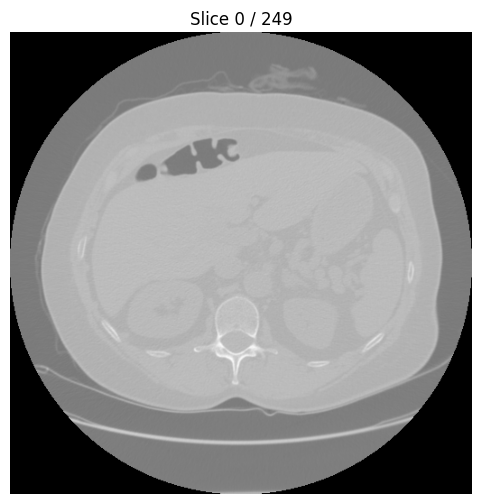

In [12]:
patient_dd.observe(on_patient_change, names="value")
thumb_count_dd.observe(on_thumb_count_change, names="value")
# ---------- Layout ----------
ui_header = w.HBox([patient_dd, thumb_count_dd, auto_detect_btn, export_btn])
ui = w.VBox([
    ui_header, 
    w.HTML("<h3>Thumbnails (🚩 = potential scout)</h3>"),
    thumb_grid, 
    w.HTML("<h3>Volume Viewer</h3>"),
    viewer_out, 
    w.HTML("<h3>Flagged Summary</h3>"),
    flagged_out
])

# Initialize
display(ui)
render_flagged_summary()
render_patient(patient_dd.value)